This notebook is intended for learning to use IFO object in pykat library
# Contents
- [1. Introduction](chap_1)
- [2. Create IFO object](chap_2) 
- [3. Run scans on Degrees of Freedom](chap_3)
- [4. Transfer function of Degrees of Freedom](chap_4)
- [5. Optimum demodulation phase](chap_5)
- [6. Optical gain](chap_6)
- [7. Sensing Matrix](chap_7)
- [8. Example : Simple Michealson Interferometer](chap_8)




#### TODO
- Need to write examples for locking


In [1]:
%matplotlib notebook
from pykat import finesse
from pykat.commands import *
import pykat.external.peakdetect as peak
import pykat.ifo.aligo as aligo
import pykat.ifo.aligo.plot as aligoplt
#import pykat
import gwinc as gwinc

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import pykat
import importlib
importlib.reload(pykat)
pykat.init_pykat_plotting(dpi=96)
import pykat.ifo as ifo
#for animations:
from matplotlib import animation, rc
from IPython.display import HTML
plt.style.use('dark_background')
# Update the matplotlib configuration parameters:
plt.rcParams.update({'text.usetex': False,
                     'lines.linewidth': 2,
                     #'font.family': 'serif',
                     #'font.serif': 'noto',
                     'font.size': 11,
                     'xtick.direction': 'in',
                     'ytick.direction': 'in',
                     'xtick.labelsize': 'small',
                     'ytick.labelsize': 'small',
                     'axes.labelsize': 'medium',
                     'axes.titlesize': 'medium',
                     'axes.grid.axis': 'both',
                     'axes.grid.which': 'both',
                     'axes.grid': True,
                     'grid.color': 'xkcd:gray',
                     'grid.alpha': 0.3,
                     'lines.markersize': 12,
                     'legend.borderpad': 0.2,
                     'legend.fancybox': True,
                     'legend.fontsize': 'small',
                     'legend.framealpha': 0.8,
                     'legend.handletextpad': 0.5,
                     'legend.labelspacing': 0.33,
                     'legend.loc': 'best',
                     'figure.figsize': ((7, 4)),
                     'savefig.dpi': 300,
                     'savefig.bbox': 'tight',
                     'pdf.compression': 9})


def radar_plot(self, detector_I, detector_Q, DOFs=None, ax=None, title=None, leg=True, autoscale=True):
    """Generates an I-Q quadrature radar plot from this sensing matrix.
    
    Each radar plot shows the magnitude and phase of the response in that
    sensor for each of the DOFs. e.g. Watts in POP_f1 per meter of ETMX motion
                    
    Parameters
    ----------
    detector_I : str
        Detector name in the sensing matrix for I quadrature
        
    detector_Q : str
        Detector name in the sensing matrix for Q quadrature
        
    DOFs : collection[str], optional
        DOFs in the sensing matrix to plot
    
    ax : axis, optional
        Matplotlib axis to put plot into
        
    title: str, optional
        Title of plot
    """
    
    I = self[detector_I]
    Q = self[detector_Q]
    
    A = I + 1j*Q
    
    # FFS, we need to standardize on the colors for the DOFs with an iron fist
    # DARM = DODGER BLUE, CARM = CARNATION, PRCL=PURPLE, MICH = MIDNIGHT, SRCL = Cyan
    clrs = ['xkcd:Dodger Blue', 'xkcd:Red', 'xkcd:Lavender', 'xkcd:Cyan', 'xkcd:Grey']
    
    _ax = ax or plt.subplot(111, projection='polar')
    _ax.set_theta_zero_location('E')
    r_lim = (np.log10(np.abs(A)).min()-1, np.log10(np.abs(A)).max())
    
    if DOFs and any((_ not in A.keys() for _ in DOFs)):
        raise Exception("Sensing matrix is missing one of DOFs ({0}) requested".format(DOFs))
        
    if DOFs:
        keys = tuple(_ for _ in A.keys() if _ in DOFs)
    else:
        keys = A.keys()
        
    scaling = np.linspace(7, 4, len(keys))
    
    for _, s, cc in zip(keys, scaling, clrs):
        theta = np.angle(A[_])
        r     = np.log10(np.abs(A[_]))
        _ax.plot((theta,theta), (r_lim[0], r), lw=s, label=_, alpha=0.6, color=cc)
    ttl = _ax.set_title(title, fontsize=11)
    ttl.set_position([.5, 1.12])
    
    if autoscale == True:
        _ax.set_ylim(r_lim[0], r_lim[1])
    else:
        _ax.set_ylim(6, 11)
    
    if leg==True:
        _ax.legend(bbox_to_anchor=(0.5, -0.1), ncol=5)
    
    _ax.set_rticks(np.arange(*np.round(r_lim)))
    _ax.set_yticklabels(tuple( "$10^{%s}$" % _ for _ in np.arange(*np.round(r_lim), dtype=int)))
    _ax.grid(True, zorder = -10, lw = 2)
    if ax is None:
        plt.tight_layout()
        plt.show()
        
def prettySensingMatrix(self, cmap = 'jet'):
    # https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html
    # Set colormap equal to seaborns light green color palette
    cmap = plt.get_cmap(cmap)

    # Set CSS properties for th elements in dataframe
    th_props = [
      ('font-size', '24'),
      ('text-align', 'center'),
      ('font-weight', 'bold'),
      ('color', 'xkcd:White'),
      ('background-color', 'xkcd:Black')
      ]

    # Set CSS properties for td elements in dataframe
    td_props = [
      ('font-size', '24')
      ]

    # Set table styles
    styles = [
      dict(selector="th", props=th_props),
      dict(selector="td", props=td_props)
      ]
        
    self = (self.style
      .background_gradient(cmap=cmap, subset=list(self))
      .set_caption('Interferometer Sensing Matrix')
      .format("{:0.3g}")
      .set_table_styles(styles))
    
    return self

                                              ..-
    PyKat 1.2.2           _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



<a name=chap_1></a>
## 1. Introduction 
This notebook is intended for newbies. This notebook shows few features of IFO module, in pykat library. The advantage of using this module is, one need not write the kat code for scanning, for finding dc gain. IFO module contains codes for finding optimum phase for demodulation, optical gain (dc gain), sensing matrix etc. 

#### Workflow
1. Write base kat code containing the components of the optical layout, with out detectors and axis commands
2. Create a kat object using finesse.kat() and parse the base kat code
3. Create a IFO object 
4. Create Output objects
5. Create DOF objects
6. Run simulations by member functions of IFO object to get scan of DOF, frequency response of DOF, DC gain, etc. 

<a name=chap_2></a>
## 2. Create IFO object.
Write kat code describing the optical layout. The following is the example PDH setup for locking laser to cavity. Create IFO object. Create output ports required for observing various degrees of freedom. Create degrees of freedom object for each DOF. 

In [2]:
#The following PDH code is available in Finesse Manual
pdh_code = '''
#------------------------------------------------------------------
# pdh.kat test file for Finesse 1.1
# (Transfer function of the Pound-Drever-Hall signal)
#
# http://www.gwoptics.org/finesse/ 
# 01.11.2013
#
# The "#" is used for comment lines. 
#
#                                                        
#                        m1                               m2           
#         .-----.       .-.                               .-.          
#         |     |       | |      . . . . . . . . . .      | |          
# --> n1  | EOM | n2 n3 | |  n4  .    None  s_cav      .  n5  | | 
#         |     |       | |      . . . . . . . . . .      | |          
#         `-----'       | |                               | |          
#                       `-'                               `-'          
#------------------------------------------------------------------
const CAV_LEN 1200
l i1 1 0 n0                   # laser P=1W f_offset=0Hz
s s0 1 n0 n1
mod eo1 40k 0.3 3 pm n1 n2  # phase modulator f_mod=40kHz
                            # midx=0.3 order=3 
s s1 1 n2 n3

m m1 0.9999 0.0001 0 n3 n4  # mirror R=0.9999 T=0.0001, phi=0
s s2 $CAV_LEN n4 n5             # space  L=1200           
m m2 1 0 0 n5 dump          # mirror R=1 T=0 phi=0

'''
basekat = finesse.kat()
basekat.verbose = False
basekat.parse(pdh_code,
              keepComments = False, 
              preserveConstants = True)
# Create IFO object
basekat.IFO = ifo.IFO(basekat,   #kat object 
                      ['phase'], #list of tuning keys (ex. phase for mirrors)
                      ['m2'])    #list of tuning componets (ex. components whose elements
                                 #needed to be varied.)

#Create a frequency attribute, which will be later used for creating output objects.
#if this frequency attribute is varied, the output objects (ports) created using this 
#frequency will change.
#Example case : If modulation frequnecy is change, one need to change the demodulation 
#frequency of the outputs. Changing the frequnecy attribute will change frequency all the
#associated output objects.
basekat.IFO.mod_freq = float(basekat.eo1.f)   # Modulation Freqency

# Create Output objects (Ports)
basekat.IFO.REFL = ifo.Output(IFO= basekat.IFO,#The output referred to ifo obj
                              name= "REFL",    #Name of the photodiode to appear in kat file
                              nodeNames="n3",  #Node to which detector is connected
                              f_property_name="mod_freq",#Name of the frequency attribute 
                                                         #in created IFO object
                              phase= 179.0)    #"I" phase of the detector.

# Create Degree Of Freedom
basekat.IFO.CAV_LEN = ifo.DOF(IFO = basekat.IFO, #This DOF referes to ifo obj
                              _DOFName="CAV_LEN",#Name of the DOF
                              _port= basekat.IFO.REFL,#Output from which signal is extracted
                              _quad="I",    #quadrature of the signal "I", "Q", "" 
                                            #for DC
                              _optics=["m2"],#List of the optics that will move as per
                                             #defined DOF.
                              _factors=[1],  #list of factors in which optics will be moved
                              _scale=1,      #Scaling
                              sigtype="z")   #Signal type

basekat.IFO.update()

<a name=chap_3></a>
## 3. Scanning Degree of Freedom
Calling scan method of DOF object appends photodiode, xaxis, yaxis commands to the existing kat code, and runs the kat code and returns katrun object 

The following commands are parsed
var scan 0
set scanre scan re
xaxis scan re lin -100 100 200
func scm2 = (1) * (1) * $scanre
noplot scm2
put m2 phi $scm2

The following commands are parsed
['pd1 REFL_I 40000.0 179.0 n3']
# Kat Code Starts##############################
% Generated by PyKat 12.07.2020 15:01:10

const CAV_LEN 1200.0
l i1 1.0 0.0 0.0 n0
s s0 1.0 n0 n1
mod eo1 40000.0 0.3 3 pm 0.0 n1 n2
s s1 1.0 n2 n3
m m1 0.9999 0.0001 0.0 n3 n4
s s2 $CAV_LEN n4 n5
m m2 1.0 0.0 0.0 n5 dump
var scan 0.0
set scanre scan re
xaxis scan re lin -100 100 200
noplot scm2
func scm2 = (1) * (1) * $scanre
put m2 phi $scm2
pd1 REFL_I 40000.0 179.0 n3
yaxis abs

# Kat Code ends################################


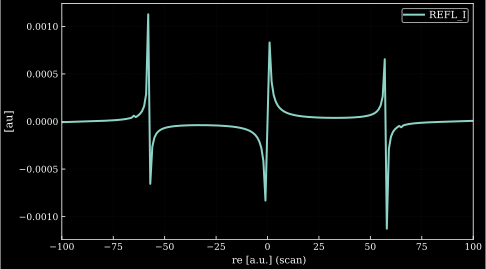

In [3]:
out = basekat.IFO.CAV_LEN.scan(xlimits = [-100,100], #finesse xaxis command min and max 
                               steps = 200,          #finesse xaxis steps
                               relative = False,      #Add "*" to "put" commands in Finesse
                               extra_cmds = None)    #Adds extra commands to kat  
                                               #by default it adds "yaxis abs"
                                               #for getting phase information add code by
                                               #passing extra_cmds = "yaxis abs:deg"
#The following kat code will run upon the "scan" method call.
pdh_dof_scan_code = '''
% Generated by PyKat 12.06.2020 20:56:54
const CAV_LEN 1200.0
l i1 1.0 0.0 0.0 n0
s s0 1.0 n0 n1
mod eo1 40000.0 0.3 3 pm 0.0 n1 n2
s s1 1.0 n2 n3
m m1 0.9999 0.0001 0.0 n3 n4
s s2 $CAV_LEN n4 n5
m m2 1.0 0.0 0.0 n5 dump
# Appended Kat Code Starts##############################
var scan 0.0
set scanre scan re
xaxis scan re lin -100 100 200
noplot scm2
func scm2 = (1) * (1) * $scanre
put m2 phi $scm2
pd1 REFL_I 40000.0 179.0 n3
yaxis abs
# Appended Kat Code ends################################
'''
out.plot()

<a name=chap_4></a>
## 4 Transfer Function of Degree of Freedom
Calling scan_f method of DOF object will generate transfer function by appending fsig commands to the kat code.

The following commands are parsed.

fsig _CAV_LEN m2 z 1 0.0 1
xaxis _CAV_LEN f log 0.1 100 1000

The following commands are parsed.
['pd2 REFL_I_TF 40000.0 179.0 $fs n3']
#Code Starts##################################
% Generated by PyKat 12.07.2020 15:01:10

const CAV_LEN 1200.0
l i1 1.0 0.0 0.0 n0
s s0 1.0 n0 n1
mod eo1 40000.0 0.3 3 pm 0.0 n1 n2
s s1 1.0 n2 n3
m m1 0.9999 0.0001 0.0 n3 n4
s s2 $CAV_LEN n4 n5
m m2 1.0 0.0 0.0 n5 dump
xaxis _CAV_LEN f log 0.1 100 1000
pd2 REFL_I_TF 40000.0 179.0 $fs n3
fsig _CAV_LEN m2 z 1.0 0.0 1.0
yaxis abs

#Code ends####################################


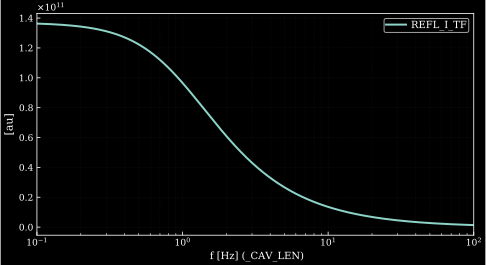

In [4]:
out = basekat.IFO.CAV_LEN.scan_f(linlog = 'log', #linlog in "xaxis" command of Finesse
                                 lower = 0.1,    #min in "xaxis" command of Finesse
                                 upper = 100,    #max in "xaxis" command of Finesse
                                 steps = 1000)   #steps in "xaxis" command of Finesse
#The following kat code will run upon the "scan_f" method call.
pdh_dof_scan_f_code = '''
% Generated by PyKat 12.06.2020 21:24:03
const CAV_LEN 1200.0
l i1 1.0 0.0 0.0 n0
s s0 1.0 n0 n1
mod eo1 40000.0 0.3 3 pm 0.0 n1 n2
s s1 1.0 n2 n3
m m1 0.9999 0.0001 0.0 n3 n4
s s2 $CAV_LEN n4 n5
m m2 1.0 0.0 0.0 n5 dump
#Appended Code Starts##################################
xaxis _CAV_LEN f log 0.1 100 1000
pd2 REFL_I_TF 40000.0 179.0 $fs n3
fsig _CAV_LEN m2 z 1.0 0.0 1.0
yaxis abs
#Appended Code ends####################################
'''
out.plot() #The gain is Watts per meter movement DOF

<a name=chap_5></a>
## 5 Methods of finding optimum demodulation phase
There are two methods "optimise_demod_phase()" and "opt_demod_phase()" defined in the ifo module. 

"opt_demod_phase()" method is more like general utility function. This take complex array generated by run() method of the kat object. see source for more details

"optimise_demod_phase()" method takes kat object, list of DOFs, list of the output ports whose demod phase need to be maximized.

The following commands are parsed
var scan 0
set scanre scan re
xaxis scan re lin -0.01 0.01 200
func scm2 = (1) * (1) * $scanre
noplot scm2
put m2 phi $scm2

The following commands are parsed
['pd1 REFL_I 40000.0 179.0 n3']
The following commands are parsed
yaxis re:im
# Kat Code Starts##############################
% Generated by PyKat 12.07.2020 15:01:11

const CAV_LEN 1200.0
l i1 1.0 0.0 0.0 n0
s s0 1.0 n0 n1
mod eo1 40000.0 0.3 3 pm 0.0 n1 n2
s s1 1.0 n2 n3
m m1 0.9999 0.0001 0.0 n3 n4
s s2 $CAV_LEN n4 n5
m m2 1.0 0.0 0.0 n5 dump
var scan 0.0
set scanre scan re
xaxis scan re lin -0.01 0.01 200
noplot scm2
func scm2 = (1) * (1) * $scanre
put m2 phi $scm2
pd1 REFL_I 40000.0 179.0 n3
yaxis lin re:im

# Kat Code ends################################


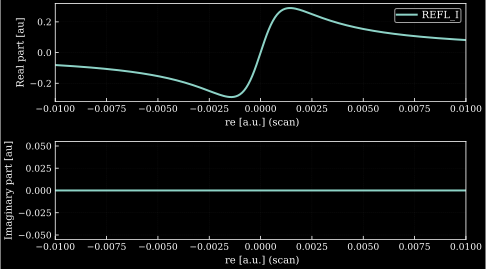

Demodulation Phase : 0.0
Otpical Gain : 402.87768666999403


In [5]:
out = basekat.IFO.CAV_LEN.scan(xlimits = [-0.01,0.01], #finesse xaxis command min and max 
                               steps = 200,          #finesse xaxis steps
                               relative = False,      #Add "*" to "put" commands in Finesse
                               extra_cmds = "yaxis re:im")
out.plot()
cdata = out['REFL_I']
demod_phase, optical_gain = ifo.opt_demod_phase(cdata=cdata, #complex array 
                                                x = out.x,   #xaxis to calculate gain
                                                xbounds = np.array([-0.001, 0.001])) 
                                                #bounds in which optimization searches 
                                                #for zero crossing
print("Demodulation Phase : " + str(demod_phase))
print("Otpical Gain : " + str(optical_gain))

In [6]:
demod_phase = ifo.optimise_demod_phase(basekat.IFO.kat,      #Associated kat object
                                       basekat.IFO.CAV_LEN,  #DOF
                                       [basekat.IFO.REFL])   #list of corresponding outputs
print(demod_phase)
pdh_optimise_demod_phase_code = '''
% Generated by PyKat 12.06.2020 21:24:03
const CAV_LEN 1200.0
l i1 1.0 0.0 0.0 n0
s s0 1.0 n0 n1
mod eo1 40000.0 0.3 3 pm 0.0 n1 n2
s s1 1.0 n2 n3
m m1 0.9999 0.0001 0.0 n3 n4
s s2 $CAV_LEN n4 n5
m m2 1.0 0.0 0.0 n5 dump
#Appended kat code ############################
var x 0
diff x re
deriv_h 1e-12
set _dx x re
func scm2 = (1) * (1) * (1) * $_dx
noplot scm2
put* m2 phi $scm2

var scan 0
xaxis scan re lin -180 180 100
put REFL_I phase1 $x1
#Appended kat code ends ########################
'''

The following commands will be parsed
['pd1 REFL_I 40000.0 179.0 n3']
Check IFO kat file
The followng lines are parsed
var x 0
diff x re
deriv_h 1e-12
set _dx x re
func scm2 = (1) * (1) * (1) * $_dx
noplot scm2
put* m2 phi $scm2

var scan 0
xaxis scan re lin -180 180 100
put REFL_I phase1 $x1

[179.95377990433818]


<a name=chap_6></a>

## 6. Optical Gain 
Following are the methods to find the optical gain (DC gain) or slope of the error signal at zero crossing. 

demod_phase, og = opt_demod_phase() method returns optical gain at zero crossing along with the demod_phase. units of optical gain is units of yaxis / units of xaxis

ifo.optical_gain() this method calculates dc gain and ac gain at given frequency.

In [7]:
out = basekat.IFO.CAV_LEN.scan(xlimits = [-0.01,0.01], #finesse xaxis command min and max 
                               steps = 200,          #finesse xaxis steps
                               relative = False,      #Add "*" to "put" commands in Finesse
                               extra_cmds = "yaxis re:im")
cdata = out['REFL_I']
demod_phase, optical_gain = ifo.opt_demod_phase(cdata=cdata, #complex array 
                                                x = out.x,   #xaxis to calculate gain
                                                xbounds = np.array([-0.001, 0.001])) 
                                                #bounds in which optimization searches 
                                                #for zero crossing
print("Demodulation Phase : " + str(demod_phase))
print("Otpical Gain (W/deg): " + str(optical_gain) + "Watts/")

The following commands are parsed
var scan 0
set scanre scan re
xaxis scan re lin -0.01 0.01 200
func scm2 = (1) * (1) * $scanre
noplot scm2
put m2 phi $scm2

The following commands are parsed
['pd1 REFL_I 40000.0 179.95377990433818 n3']
The following commands are parsed
yaxis re:im
# Kat Code Starts##############################
% Generated by PyKat 12.07.2020 15:01:12

const CAV_LEN 1200.0
l i1 1.0 0.0 0.0 n0
s s0 1.0 n0 n1
mod eo1 40000.0 0.3 3 pm 0.0 n1 n2
s s1 1.0 n2 n3
m m1 0.9999 0.0001 0.0 n3 n4
s s2 $CAV_LEN n4 n5
m m2 1.0 0.0 0.0 n5 dump
var scan 0.0
set scanre scan re
xaxis scan re lin -0.01 0.01 200
noplot scm2
func scm2 = (1) * (1) * $scanre
put m2 phi $scm2
pd1 REFL_I 40000.0 179.95377990433818 n3
yaxis lin re:im

# Kat Code ends################################
Demodulation Phase : 0.0
Otpical Gain (W/deg): 402.93351394776886Watts/


In [8]:
out = ifo.optical_gain(DOF_sig=basekat.IFO.CAV_LEN, #DOF
                       DOF_det=basekat.IFO.CAV_LEN, #DOF
                       f = 0.01, #frequency at which optical gain to be calculated
                       useDiff=True) #True will calulate dc slope of error signal
                                     #Flase will use fsig command to calculate the gain
                                     #frequency is given at f
print("optical gain using ifo.optical_gain() [W/rad]: " + str(out))
print("optical gain using ifo.optical_gain() [W/deg]: " + str(out*np.pi/180.0))
pdh_optical_gain_code = '''

% Generated by PyKat 12.06.2020 22:50:05

const CAV_LEN 1200.0
l i1 1.0 0.0 0.0 n0
s s0 1.0 n0 n1
mod eo1 40000.0 0.3 3 pm 0.0 n1 n2
s s1 1.0 n2 n3
m m1 0.9999 0.0001 0.0 n3 n4
s s2 $CAV_LEN n4 n5
m m2 1.0 0.0 0.0 n5 dump
#Appended kat code starts ##############################
var x 0.0
diff x re
set _dx x re
noplot scm2
func scm2 = (1) * (1) * (1) * $_dx
put* m2 phi $scm2
pd1 REFL_I 40000.0 179.95377990433818 n3
noxaxis
yaxis lin abs
deriv_h 1e-08
#Appended kat code ends ################################'''

The following commands will be parsed
var x 0
diff x re
deriv_h 1e-08
set _dx x re
func scm2 = (1) * (1) * (1) * $_dx
noplot scm2
put* m2 phi $scm2

['pd1 REFL_I 40000.0 179.95377990433818 n3']
#kat code starts ##############################
% Generated by PyKat 12.07.2020 15:01:13

const CAV_LEN 1200.0
l i1 1.0 0.0 0.0 n0
s s0 1.0 n0 n1
mod eo1 40000.0 0.3 3 pm 0.0 n1 n2
s s1 1.0 n2 n3
m m1 0.9999 0.0001 0.0 n3 n4
s s2 $CAV_LEN n4 n5
m m2 1.0 0.0 0.0 n5 dump
var x 0.0
diff x re
set _dx x re
noplot scm2
func scm2 = (1) * (1) * (1) * $_dx
put* m2 phi $scm2
pd1 REFL_I 40000.0 179.95377990433818 n3
noxaxis
yaxis lin abs
deriv_h 1e-08

#kat code ends ################################
optical gain using ifo.optical_gain() [W/rad]: 23198.89878502624
optical gain using ifo.optical_gain() [W/deg]: 404.89716663562


In [9]:
out = ifo.optical_gain(DOF_sig=basekat.IFO.CAV_LEN, #DOF
                       DOF_det=basekat.IFO.CAV_LEN, #DOF
                       f = 0.01, #frequency at which optical gain to be calculated
                       useDiff=False) #True will calulate dc slope of error signal
                                     #Flase will use fsig command to calculate the gain
                                     #frequency is given at f
print("optical gain using ifo.optical_gain() [W/rad]: " + str(out))
print("optical gain using ifo.optical_gain() [W/deg]: " + str(out*np.pi/180.0))

The following commands will be parsed

fsig sig1 m2 z 0.01 0.0 1
['pd2 REFL_I_TF 40000.0 179.95377990433818 $fs n3']
#kat code starts ##############################
% Generated by PyKat 12.07.2020 15:01:13

const CAV_LEN 1200.0
l i1 1.0 0.0 0.0 n0
s s0 1.0 n0 n1
mod eo1 40000.0 0.3 3 pm 0.0 n1 n2
s s1 1.0 n2 n3
m m1 0.9999 0.0001 0.0 n3 n4
s s2 $CAV_LEN n4 n5
m m2 1.0 0.0 0.0 n5 dump
pd2 REFL_I_TF 40000.0 179.95377990433818 $fs n3
fsig sig1 m2 z 0.01 0.0 1.0
noxaxis
yaxis lin abs:deg

#kat code ends ################################
optical gain using ifo.optical_gain() [W/rad]: 23196.55141933784
optical gain using ifo.optical_gain() [W/deg]: 404.8561973756092


In [10]:
#Finding DC gain (slope of error signal) using the commands generated by IFO object
kat_obj = basekat.IFO.kat.deepcopy()
kat_obj.verbose = False
kat_obj.parse('noxaxis')
kat_obj.parse(basekat.IFO.REFL.get_diff_cmds()) #Returns photodiode 
kat_obj.parse(basekat.IFO.CAV_LEN.dcsig()) #Returns commands to get dc gain
out = kat_obj.run()
og = out.y[0][0]
print("Optical gain (W/deg): " + str(og))

Optical gain (W/deg): 404.89716663562


<a name=chap_7></a>

## 7. Sensing Matrix
sensing_matrix() method of IFO object returns sensing matrix for the given DOF names and the detectors. Sensing_Matrix object is derived from Pandas Dataframe object.

The following commands will be parsed
['pd2 REFL_I_TF 40000.0 179.95377990433818 $fs n3']
Check IFO kat file
The following commands will be parsed
['pd2 REFL_Q_TF 40000.0 269.95377990433815 $fs n3']
Check IFO kat file
#kat code starts###################################
% Generated by PyKat 12.07.2020 15:01:13

const CAV_LEN 1200.0
l i1 1.0 0.0 0.0 n0
s s0 1.0 n0 n1
mod eo1 40000.0 0.3 3 pm 0.0 n1 n2
s s1 1.0 n2 n3
m m1 0.9999 0.0001 0.0 n3 n4
s s2 $CAV_LEN n4 n5
m m2 1.0 0.0 0.0 n5 dump
pd2 REFL_I_TF 40000.0 179.95377990433818 $fs n3
pd2 REFL_Q_TF 40000.0 269.95377990433815 $fs n3
fsig CAV_LEN_fsig m2 z 0.01 0.0 1.0
noxaxis
yaxis lin re:im

#kat code ends#####################################
Optical Gain (W/m) : 136981420164.68
Optical Gain (W/rad) : 23196.551419337873
Optical Gain (W/deg) : 404.8561973756098
The following commands will be parsed
['pd2 REFL_I_TF 40000.0 179.95377990433818 $fs n3']
Check IFO kat file


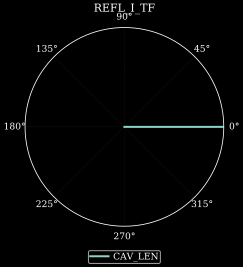

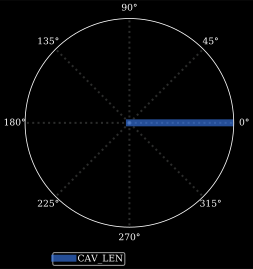

In [11]:
DOFs = ['CAV_LEN'] 
detectors = [basekat.IFO.REFL.add_transfer(quad='I'), 
             basekat.IFO.REFL.add_transfer(quad='Q')]

sens_matrix = basekat.IFO.sensing_matrix(DOFs= DOFs, #list of DOFs or DOF names
                                         detectors= detectors, #List to detector
                                         frequency= 0.01) #frequency 

og = sens_matrix['REFL_I_TF']['CAV_LEN'] #syntax : dataframe[column name][row name]
print("Optical Gain (W/m) : " + str(og))
og_w_rad = og*basekat.lambda0/(2.0*np.pi)
print("Optical Gain (W/rad) : " + str(og_w_rad))
og_w_deg = og*basekat.lambda0/(360.0)
print("Optical Gain (W/deg) : " + str(og_w_deg))

prettySensingMatrix(sens_matrix) #This function takes dataframe as input defined at the 
                                 #starting of the notebook
sens_matrix.radar_plot(basekat.IFO.REFL.add_transfer(quad='I')) #This function takes name 
                                                       #of the detector as input

radar_plot(sens_matrix,'REFL_I_TF', 'REFL_Q_TF') # This function is defined at the starting
                                                 # of the notebook. This take sensing_matrix
                                                 # dataframe, I, Q detector name mentioned
                                                 # in the column names of the dataframe
pdh_sens_matrix_code = '''

% Generated by PyKat 12.06.2020 23:33:20

const CAV_LEN 1200.0
l i1 1.0 0.0 0.0 n0
s s0 1.0 n0 n1
mod eo1 40000.0 0.3 3 pm 0.0 n1 n2
s s1 1.0 n2 n3
m m1 0.9999 0.0001 0.0 n3 n4
s s2 $CAV_LEN n4 n5
m m2 1.0 0.0 0.0 n5 dump
#kat code starts###################################
pd2 REFL_I_TF 40000.0 179.95377990433818 $fs n3
pd2 REFL_Q_TF 40000.0 269.95377990433815 $fs n3
fsig CAV_LEN_fsig m2 z 0.01 0.0 1.0
noxaxis
yaxis lin re:im

#kat code ends#####################################'''


<a name=chap_8></a>

## 8. Example : Simple Michealson Interferometer

In [12]:
# Note michealson is not operating at dark fringe. It is operating slope of maximum.
basekat=finesse.kat() # initialising Finesse
basekat.verbose = False
basecode = """
l laser 1 0 0 n0    # Laser (Power = 1 W, wavelength offset = 0, init phase = 0)
s s-w 1 n0 n1       # Space (Length = 1 m)
bs bs1 0.5 0.5 0 45 n1 n2 n3 n4   # Beam splitter R = 0.5, T = 0.5, 
                                  #  phi = 0, AoI = 45
s s-n 1000 n2 n5                  # Space 1000m Ly 
m1 ETMY 5e-06 3.75e-05 0 n5 dump  # Mirror_y R = 1, T = 0, phi = 0           
s s-e 1000 n3 n6                  # Space 1000m Lx
m1 ETMX 5e-06 3.75e-05 45 n6 dump               # Mirror_x R = 1, T = 0, phi = 0
"""
basekat.parse(basecode,
              keepComments = False, 
              preserveConstants = True)
# Create IFO object
basekat.IFO = ifo.IFO(basekat,   #kat object 
                      ['phase'], #list of tuning keys (ex. phase for mirrors)
                      ['ETMX','ETMY'])    #list of tuning componets (ex. components whose elements
                                 #needed to be varied.)

# Create Output objects (Ports)
basekat.IFO.AS_DC = ifo.Output(IFO= basekat.IFO,#The output referred to ifo obj
                              name= "AS_DC",    #Name of the photodiode to appear in kat file
                              nodeNames="n4",  #Node to which detector is connected
                              f_property_name=None,#Name of the frequency attribute 
                                                         #in created IFO object
                              phase= None)    #"I" phase of the detector.

# Create Degree Of Freedom
basekat.IFO.DARM = ifo.DOF(IFO = basekat.IFO, #This DOF referes to ifo obj
                              _DOFName="DARM",#Name of the DOF
                              _port= basekat.IFO.AS_DC,#Output from which signal is extracted
                              _quad="",    #quadrature of the signal "I", "Q", "" 
                                            #for DC
                              _optics=["ETMX","ETMY"],#List of the optics that will move as per
                                             #defined DOF.
                              _factors=[1, -1],  #list of factors in which optics will be moved
                              _scale=1,      #Scaling
                              sigtype="z")   #Signal type

basekat.IFO.update()

The following commands are parsed
var scan 0
set scanre scan re
xaxis scan re lin -100 100 200
func scETMX = (1) * (1) * $scanre
noplot scETMX
put* ETMX phi $scETMX
func scETMY = (1) * (-1) * $scanre
noplot scETMY
put* ETMY phi $scETMY

The following commands are parsed
['pd AS_DC n4']
# Kat Code Starts##############################
% Generated by PyKat 12.07.2020 15:01:14

l laser 1.0 0.0 0.0 n0
s s-w 1.0 n0 n1
bs bs1 0.5 0.5 0.0 45.0 n1 n2 n3 n4
s s-n 1000.0 n2 n5
m1 ETMY 5e-06 3.75e-05 0.0 n5 dump
s s-e 1000.0 n3 n6
m1 ETMX 5e-06 3.75e-05 45.0 n6 dump
var scan 0.0
set scanre scan re
xaxis scan re lin -100 100 200
noplot scETMX
func scETMX = (1) * (1) * $scanre
put* ETMX phi $scETMX
noplot scETMY
func scETMY = (1) * (-1) * $scanre
put* ETMY phi $scETMY
pd0 AS_DC n4
yaxis abs

# Kat Code ends################################


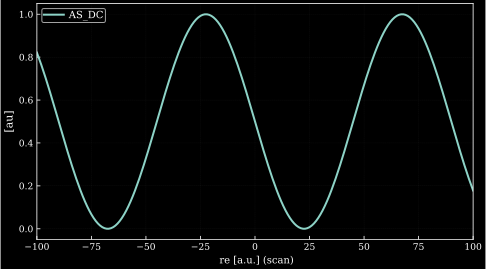

In [13]:
#scanning degree of freedom
out = basekat.IFO.DARM.scan(xlimits = [-100,100], #finesse xaxis command min and max 
                               steps = 200,          #finesse xaxis steps
                               relative = True,      #Add "*" to "put" commands in Finesse
                               extra_cmds = None)    #Adds extra commands to kat  
                                               #by default it adds "yaxis abs"
                                               #for getting phase information add code by
                                               #passing extra_cmds = "yaxis abs:deg"
out.plot()

The following commands are parsed.

fsig _DARM ETMX z 1 0.0 1
fsig _DARM ETMY z 1 180.0 1
xaxis _DARM f log 0.1 1000 1000

The following commands are parsed.
['pd1 AS_DC_TF $fs n4']
#Code Starts##################################
% Generated by PyKat 12.07.2020 15:01:14

l laser 1.0 0.0 0.0 n0
s s-w 1.0 n0 n1
bs bs1 0.5 0.5 0.0 45.0 n1 n2 n3 n4
s s-n 1000.0 n2 n5
m1 ETMY 5e-06 3.75e-05 0.0 n5 dump
s s-e 1000.0 n3 n6
m1 ETMX 5e-06 3.75e-05 45.0 n6 dump
xaxis _DARM f log 0.1 1000 1000
pd1 AS_DC_TF $fs n4
fsig _DARM ETMX z 1.0 0.0 1.0
fsig _DARM ETMY z 1.0 180.0 1.0
yaxis abs

#Code ends####################################


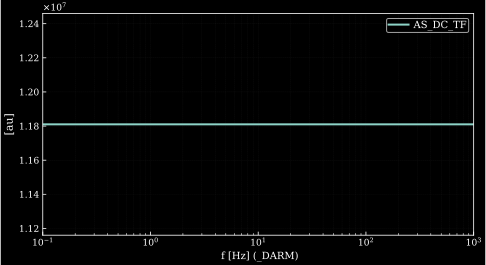

In [14]:
#Transfer function of the DOF gain units (W/m)
out = basekat.IFO.DARM.scan_f(linlog = 'log', #linlog in "xaxis" command of Finesse
                                 lower = 0.1, #min in "xaxis" command of Finesse
                                 upper = 1000,#max in "xaxis" command of Finesse
                                 steps = 1000)#steps in "xaxis" command of Finesse
out.plot()

In [15]:
#This wont work for DC photodetectors
demod_phase = ifo.optimise_demod_phase(basekat.IFO.kat,      #Associated kat object
                                       basekat.IFO.DARM,  #DOF
                                       [basekat.IFO.AS_DC])   #list of corresponding outputs

BasePyKatException: port AS_DC cannot have its demodulation phase optimised as it isn't demodulated

In [ ]:
#The above commands doesnot work for DC detectors
#Finding DC gain (slope of error signal) using the commands generated by IFO object
kat_obj = basekat.IFO.kat.deepcopy()
kat_obj.verbose = False
kat_obj.parse('noxaxis')
kat_obj.parse(basekat.IFO.AS_DC.get_diff_cmds()) #Returns photodiode 
kat_obj.parse(basekat.IFO.DARM.dcsig()) #Returns commands to get dc gain
out = kat_obj.run()
og = out.y[0][0]
print("Optical gain (W/deg): " + str(og))

In [ ]:
#Generating 
DOFs = ['DARM'] 
detectors = [basekat.IFO.AS_DC.add_transfer(quad=None)]

sens_matrix = basekat.IFO.sensing_matrix(DOFs= DOFs, #list of DOFs or DOF names
                                         detectors= detectors #List to detector
                                         ) #frequency 

print(sens_matrix)

In [ ]:
og = sens_matrix['AS_DC_TF']['DARM'] #syntax : dataframe[column name][row name]
print("Optical Gain (W/m) : " + str(og))
og_w_rad = og*basekat.lambda0/(2.0*np.pi)
print("Optical Gain (W/rad) : " + str(og_w_rad))
og_w_deg = og*basekat.lambda0/(360.0)
print("Optical Gain (W/deg) : " + str(og_w_deg))

prettySensingMatrix(sens_matrix) #This function takes dataframe as input defined at the 
                                 #starting of the notebook